# AML assignment Problem 2

# Team members
- NANDINI JAISWAL - `MDS202335`
- ARITRA - `MCS202304` 

# Import necessary modules

In [1]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import warnings
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import random


warnings.filterwarnings('ignore')

# Store path to necessary directories.

In [2]:
# Global variables
DATA_DIR = '/kaggle/input/emotion-detection-fer/'
WORK_DIR = '/kaggle/working/'

# Use GPU(s) if available

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device_count = torch.cuda.device_count()
print(f"devices available: {device_count}")

device: cuda
devices available: 2


# Data loading and preprocessing

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
    transforms.Resize((224, 224)),  # Resize to 224x224 as expected by ResNet
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize as expected by ResNet
])

train_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(train_data.classes)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


# A sample demonstration of images from the dataset

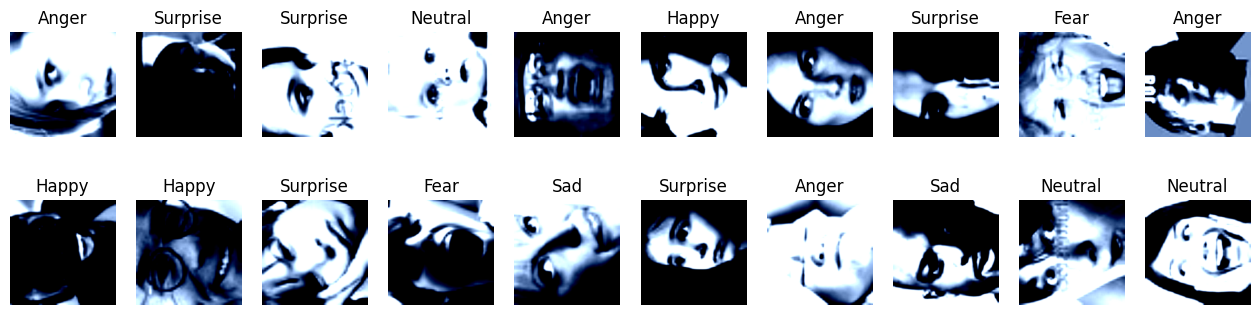

In [6]:
# Sample dictionary mapping label numbers to emotion names
emotion_dict = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

plt.figure(figsize=(16, 4))

image_batch, label_batch = next(iter(train_loader))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    
    plt.subplot(2, 10, i + 1)
    plt.imshow(image.T.squeeze().numpy())
    plt.axis('off')
    
    # Get the emotion name from the dictionary
    emotion_name = emotion_dict.get(label, "Unknown")
    
    # Display the emotion name
    plt.title(f'{emotion_name}')

# Function to evaluate model performance

In [7]:
def evaluate_model(model):
    """Returns accuracy score given predicted and actual labels"""
    model.eval()
    all_preds = []
    all_labels = []
    
    # Set no_grad so that the model doesn't get trained while testing 
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy score for the predictions against actual labels
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Building `ResNet-18` classifier from scratch for emotion detection dataset


In [8]:
model_scratch = models.resnet18(pretrained=False)
model_scratch.fc = nn.Linear(model_scratch.fc.in_features, 7)

model_scratch = nn.DataParallel(model_scratch)
model_scratch.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model_scratch.train()
    running_loss = 0.0
    
    # This progress bar helps track the progress and the loss after each epoch
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    
    count = 0
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_scratch(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        count = count + 1

        running_loss += loss.item()
        
         # Update the progress bar with running loss
        progress_bar.set_postfix(loss=running_loss / count)

    print(f'Accuracy on test dataset: {evaluate_model(model_scratch)}')

print("Training complete for ResNet-18 from scratch!")


Epoch 1/10: 100%|██████████| 898/898 [03:40<00:00,  4.07it/s, loss=1.72]


Accuracy on test dataset: 0.36765115631095013


Epoch 2/10: 100%|██████████| 898/898 [02:12<00:00,  6.78it/s, loss=1.37]


Accuracy on test dataset: 0.5245193647255503


Epoch 3/10: 100%|██████████| 898/898 [02:14<00:00,  6.68it/s, loss=1.22]


Accuracy on test dataset: 0.5341320702145445


Epoch 4/10: 100%|██████████| 898/898 [02:14<00:00,  6.67it/s, loss=1.13]


Accuracy on test dataset: 0.5590693786570076


Epoch 5/10: 100%|██████████| 898/898 [02:13<00:00,  6.74it/s, loss=1.04]


Accuracy on test dataset: 0.5833101142379493


Epoch 6/10: 100%|██████████| 898/898 [02:14<00:00,  6.67it/s, loss=0.958]


Accuracy on test dataset: 0.5876288659793815


Epoch 7/10: 100%|██████████| 898/898 [02:14<00:00,  6.69it/s, loss=0.862]


Accuracy on test dataset: 0.6040679855112845


Epoch 8/10: 100%|██████████| 898/898 [02:13<00:00,  6.74it/s, loss=0.737]


Accuracy on test dataset: 0.6135413764279743


Epoch 9/10: 100%|██████████| 898/898 [02:14<00:00,  6.67it/s, loss=0.596]


Accuracy on test dataset: 0.6231540819169685


Epoch 10/10: 100%|██████████| 898/898 [02:15<00:00,  6.62it/s, loss=0.429]


Accuracy on test dataset: 0.6128448035664531
Training complete for ResNet-18 from scratch!


# Save the above model trained from scratch

In [13]:
model_path = "model_scratch.pth"
torch.save(model_scratch.state_dict(), model_path)
print(f"Training complete. Model saved to {model_path}")

Training complete. Model saved to model_scratch.pth


# Fine-tuning of `pretrained ResNet-18` classifier

In [19]:
model_finetuned = models.resnet18(pretrained=True)
model_finetuned.fc = nn.Linear(model_finetuned.fc.in_features, 7)

# Freeze the convolution layers
for param in model_finetuned.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layers
for param in model_finetuned.fc.parameters():
    param.requires_grad = True

# Parallelize if multiple GPUs are available
model_finetuned = nn.DataParallel(model_finetuned)

model_finetuned.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_finetuned.parameters()), lr=0.0001)

num_epochs = 10

for epoch in range(num_epochs):
    model_finetuned.train()
    running_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    
    count = 0
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_finetuned(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        count = count + 1

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / count)  # Update the progress bar with loss

    print(f'Accuracy on test dataset: {evaluate_model(model_finetuned)}')

print("Fine-tuning complete for the pre-trained ResNet-18!")


Epoch 1/10: 100%|██████████| 898/898 [01:46<00:00,  8.44it/s, loss=1.78]


Accuracy on test dataset: 0.344803566453051


Epoch 2/10: 100%|██████████| 898/898 [01:48<00:00,  8.26it/s, loss=1.64]


Accuracy on test dataset: 0.39579269991641125


Epoch 3/10: 100%|██████████| 898/898 [01:47<00:00,  8.36it/s, loss=1.58]


Accuracy on test dataset: 0.40819169685149065


Epoch 4/10: 100%|██████████| 898/898 [01:46<00:00,  8.43it/s, loss=1.55]


Accuracy on test dataset: 0.414182223460574


Epoch 5/10: 100%|██████████| 898/898 [01:45<00:00,  8.52it/s, loss=1.53]


Accuracy on test dataset: 0.4203120646419615


Epoch 6/10: 100%|██████████| 898/898 [01:46<00:00,  8.39it/s, loss=1.51]


Accuracy on test dataset: 0.42254109779882976


Epoch 7/10: 100%|██████████| 898/898 [01:45<00:00,  8.50it/s, loss=1.5] 


Accuracy on test dataset: 0.4302033992755642


Epoch 8/10: 100%|██████████| 898/898 [01:45<00:00,  8.49it/s, loss=1.49]


Accuracy on test dataset: 0.42936751184173866


Epoch 9/10: 100%|██████████| 898/898 [01:48<00:00,  8.31it/s, loss=1.48]


Accuracy on test dataset: 0.432711061577041


Epoch 10/10: 100%|██████████| 898/898 [01:47<00:00,  8.36it/s, loss=1.48]


Accuracy on test dataset: 0.4381443298969072
Fine-tuning complete for the pre-trained ResNet-18!


# Save the fine-tuned model for further use

In [31]:
model_path = "model_finetuned.pth"
torch.save(model_finetuned.state_dict(), model_path)
print(f"Training complete. Model saved to {model_path}")

Training complete. Model saved to model_finetuned.pth


# Comparison of accuracy scores

In [22]:
# Function to evaluate model performance
def evaluate_model(model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate the ResNet-18 trained from scratch
accuracy_scratch = evaluate_model(model_scratch)
print(f'Accuracy of ResNet-18 (from scratch) on test set: {accuracy_scratch:.2f}%')

# Evaluate the fine-tuned ResNet-18
accuracy_finetuned = evaluate_model(model_finetuned)
print(f'Accuracy of Fine-tuned ResNet-18 on test set: {accuracy_finetuned:.2f}%')


Accuracy of ResNet-18 (from scratch) on test set: 61.28%
Accuracy of Fine-tuned ResNet-18 on test set: 43.81%


# Function to compare the results on test images

In [ ]:
def compare_models_on_images(model_scratch, model_finetuned, test_loader, device, label_names, num_images=5):
    """
    Function to compare two models on randomly selected images from the test_loader.
    
    Args:
        model_scratch: First trained model (from scratch).
        model_finetuned: Second trained model (fine-tuned).
        test_loader: DataLoader containing test dataset.
        device: Device to run the models on ('cpu' or 'cuda').
        label_names: List of label names corresponding to label indices.
        num_images: Number of images to compare predictions on.
    
    Returns:
        None (prints and visualizes the predictions).
    """
    # Set both models to evaluation mode
    model_scratch.eval()
    model_finetuned.eval()

    # Collect all images and labels from the test_loader
    all_images = []
    all_labels = []
    for images, labels in test_loader:
        all_images.append(images)
        all_labels.append(labels)
    
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Randomly select images
    indices = random.sample(range(len(all_images)), num_images)
    selected_images = all_images[indices]
    selected_labels = all_labels[indices]
    
    # Move the images and labels to the device
    selected_images, selected_labels = selected_images.to(device), selected_labels.to(device)
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Forward pass through both models
        outputs_scratch = model_scratch(selected_images)
        outputs_finetuned = model_finetuned(selected_images)
        
        # Get the predicted class (highest score index) and probabilities
        probs_scratch = torch.softmax(outputs_scratch, dim=1)
        probs_finetuned = torch.softmax(outputs_finetuned, dim=1)
        _, predicted_scratch = torch.max(probs_scratch, 1)
        _, predicted_finetuned = torch.max(probs_finetuned, 1)
        
        # Display each image with prediction and probability graphs
        for i in range(num_images):
            plt.figure(figsize=(10, 4))
            
            # Show the image
            plt.subplot(1, 2, 1)
            plt.imshow(selected_images[i].cpu().squeeze().permute(1, 2, 0))  # Convert tensor to image
            plt.axis('off')
            plt.title(f"True Label: {label_names[selected_labels[i].item()]} \n"
                      f"Scratch: {label_names[predicted_scratch[i].item()]} | "
                      f"Finetuned: {label_names[predicted_finetuned[i].item()]}")
            
            # Plot the prediction probabilities for both models
            plt.subplot(1, 2, 2)
            bar_width = 0.35
            index = np.arange(len(label_names))
            
            plt.bar(index, probs_scratch[i].cpu().numpy(), bar_width, label='Scratch', alpha=0.7)
            plt.bar(index + bar_width, probs_finetuned[i].cpu().numpy(), bar_width, label='Finetuned', alpha=0.7)
            
            plt.xlabel('Classes')
            plt.ylabel('Probability')
            plt.xticks(index + bar_width / 2, label_names, rotation=45)
            plt.legend()
            plt.tight_layout()
            
            plt.show()


label_names = train_data.classes

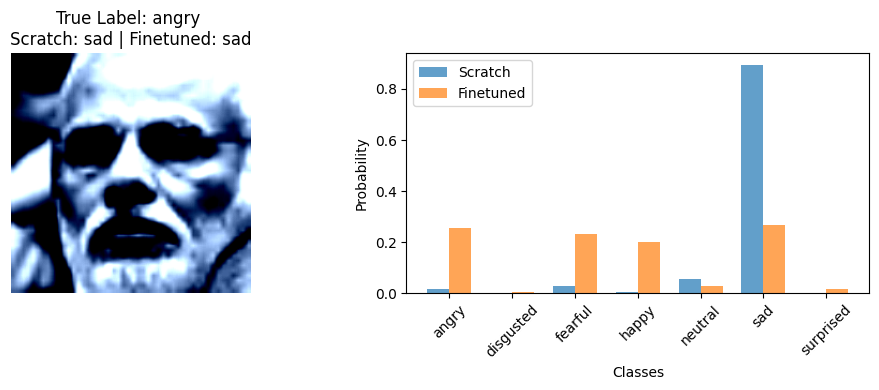

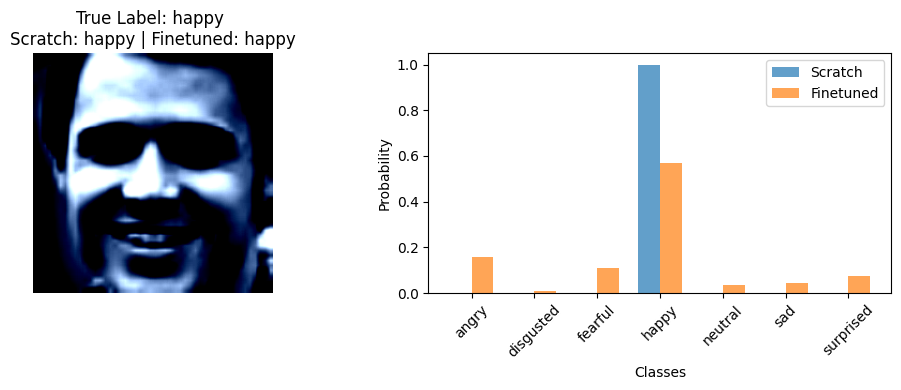

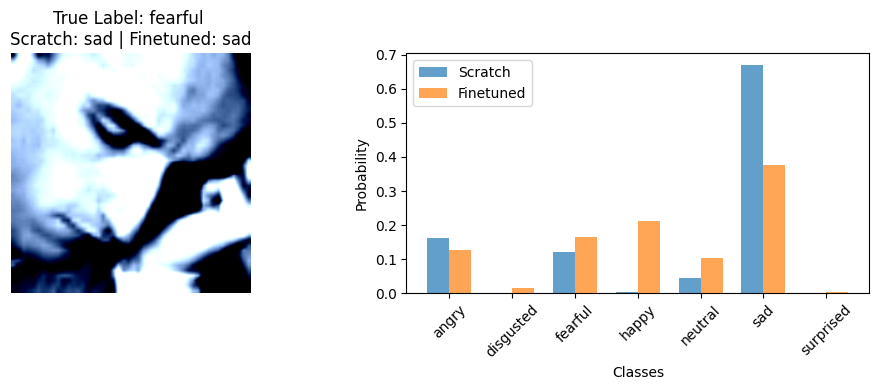

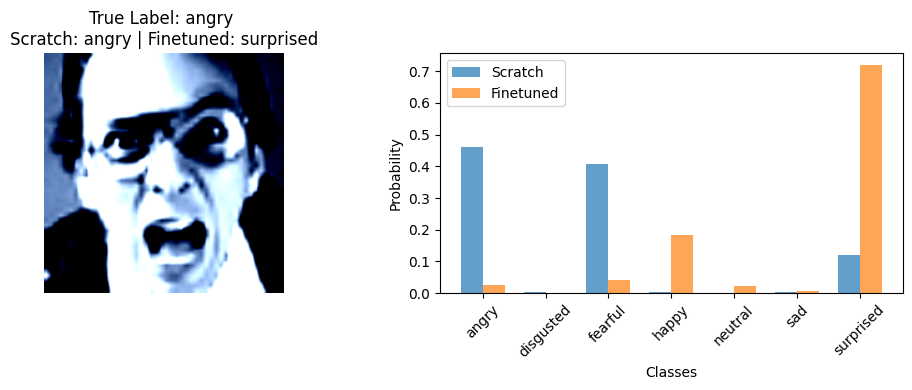

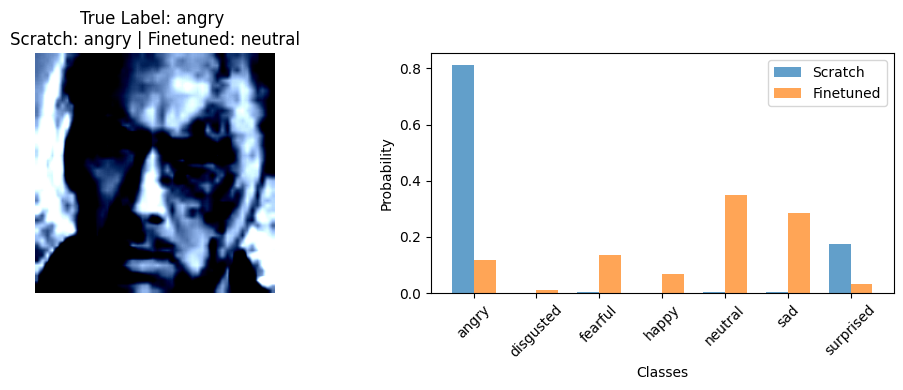

In [26]:
compare_models_on_images(model_scratch, model_finetuned, test_loader, device, label_names)

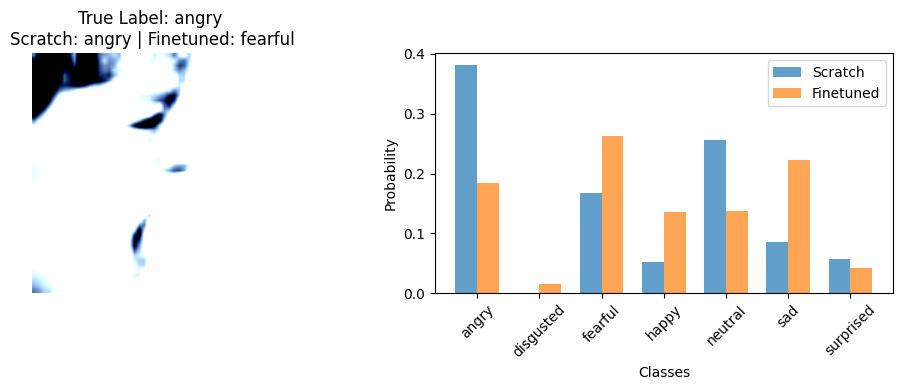

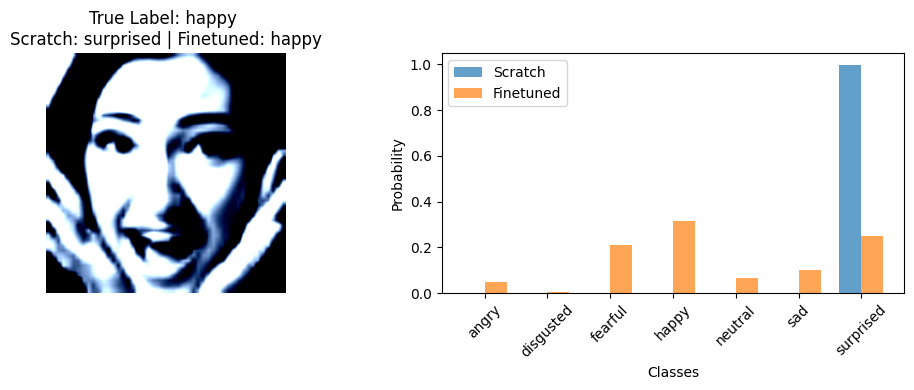

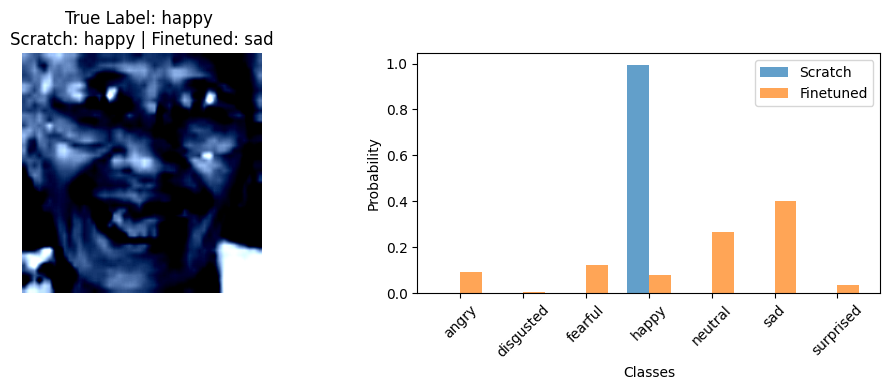

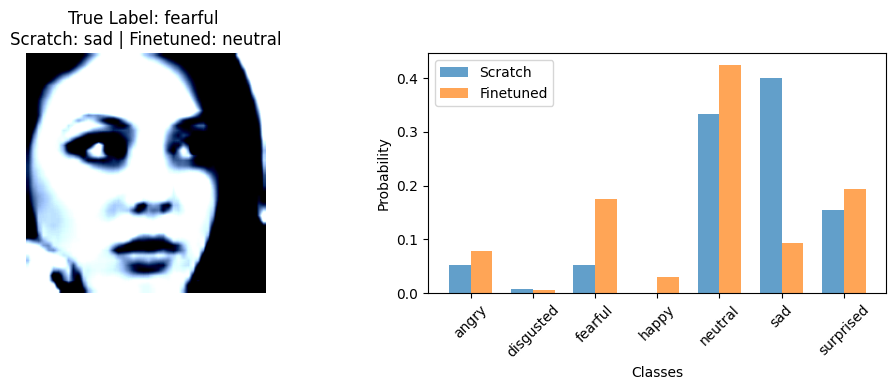

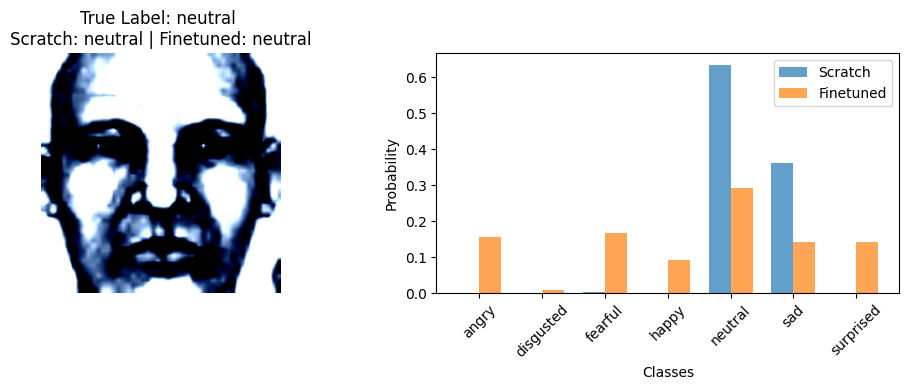

In [27]:
compare_models_on_images(model_scratch, model_finetuned, test_loader, device, label_names)

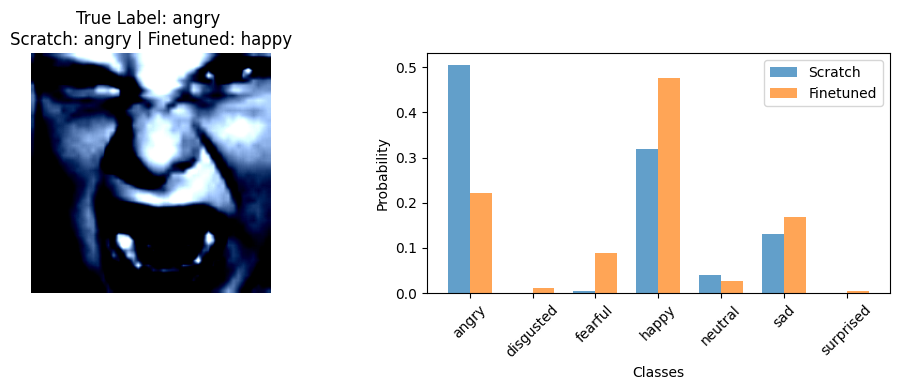

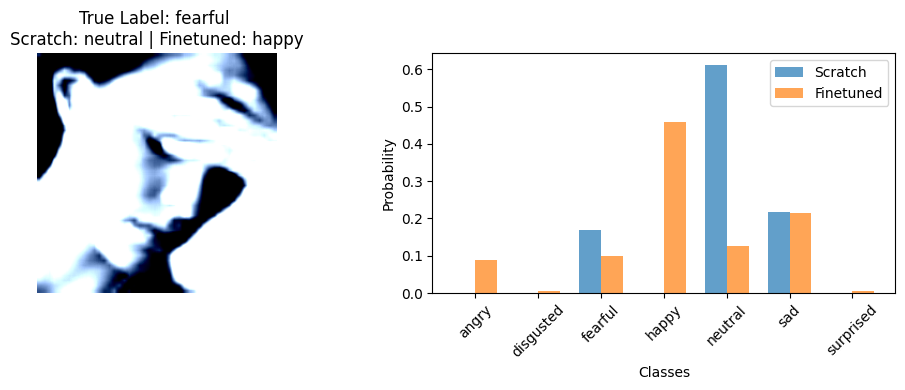

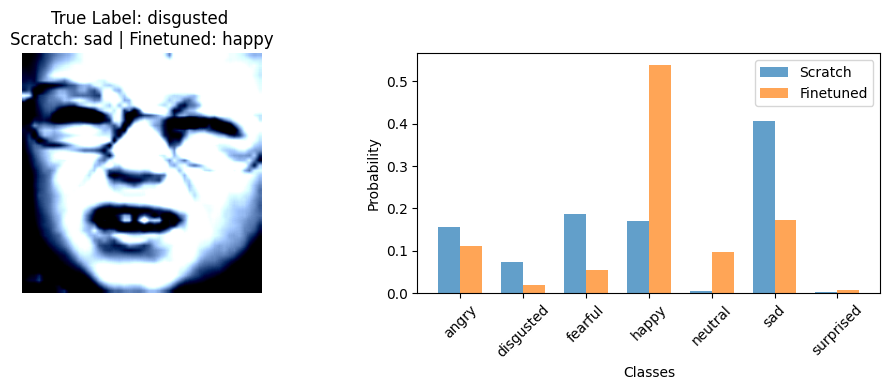

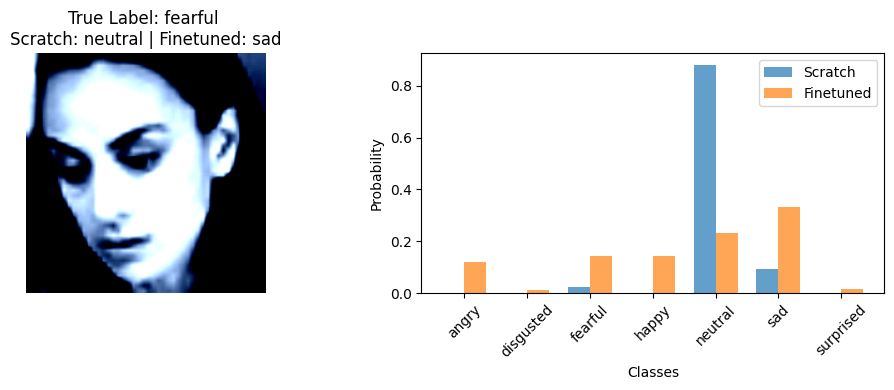

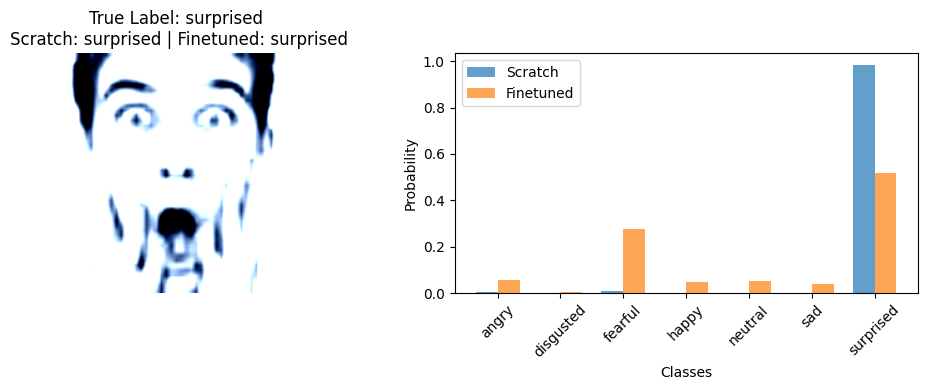

In [28]:
compare_models_on_images(model_scratch, model_finetuned, test_loader, device, label_names)

# Conclusion:

---

| Model             | Description                                           | Accuracy | Observations                                                 |
|-------------------|-------------------------------------------------------|----------|--------------------------------------------------------------|
|`ResNet-18 model built from scratch`        | Trained ResNet-18 from Scratch        | 62%      | Achieved relatively higher accuracy within 10 epochs |
| `pre-trained ResNet-18 fine-tuned`   | Fine-tuned the pre-trained ResNet-18   | 43%      | Unfreezed only the fully connected layers and finetuned using the new dataset and labels |

---

The `model built from scratch` has better accuracy.